## Hyperparameter tuning with Optuna

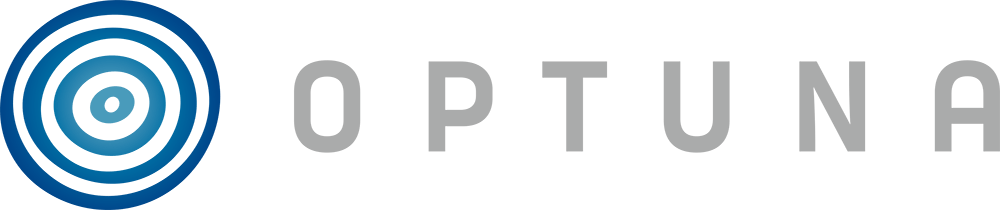

In [12]:
%%capture

!apt-get update && apt-get install -y xvfb
!pip install swig
!pip install gym[box2d]==0.23.1
!pip install pytorch-lightning==1.6.0
!pip install pyvirtualdisplay

In [13]:
!pip install pytorch-lightning

  Using cached pytorch_lightning-2.5.0.post0-py3-none-any.whl.metadata (21 kB)
  Using cached torchmetrics-1.6.2-py3-none-any.whl.metadata (20 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached pytorch_lightning-2.5.0.post0-py3-none-any.whl (819 kB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
Using cached torchmetrics-1.6.2-py3-none-any.whl (931 kB)
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


#### Setup virtual display

In [14]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [26]:
import copy
import gym
import torch
import random

import statistics

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

import pytorch_lightning as pl

from pytorch_lightning import LightningModule, Trainer

from pytorch_lightning.callbacks import EarlyStopping

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

num_gpus = torch.cuda.device_count()
# Type redeclaration for backwards compatibility.
np.bool = np.bool_

In [16]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the Deep Q-Network

In [17]:
class DQN(nn.Module):
  def __init__(self, hidden_size, obs_size, n_action):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_action)
    )
  def forward(self, x):
    return self.net(x.float())

#### Create the policy

In [18]:
def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  # select the action by P=1-epsilon
  else:
    state = torch.tensor([state]).to(device)
    q_values = net(state)
    _, action = torch.max(q_values, dim=1)
    action = int(action.item())
  return action

#### Create the replay buffer

In [19]:
class ReplayBuffer:
   def __init__(self, capacity):
     self.buffer = deque(maxlen = capacity)

   def __len__(self):
     return len(self.buffer)

   def append(self, experience):
     self.buffer.append(experience)

   def sample(self, batch_size):
     return random.sample(self.buffer, batch_size)

In [20]:
class RLDataset(IterableDataset):
  def __init__(self, buffer, sample_size = 200):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):
   for experience in self.buffer.sample(self.sample_size):
    yield experience

#### Create the environment

In [21]:
def create_environment(name):
  env = gym.make(name)
  env = TimeLimit(env, max_episode_steps=400) #normally the agent has 1000 episode steps to land, by setting this to 400 we reduce the accessible time to make it faster
  env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x % 50 == 0)
  env = RecordEpisodeStatistics(env)
  return env

In [22]:
!pip uninstall -y pygame box2d-py
!pip install pygame==2.1.3 box2d-py
!pip install gym[box2d]

Found existing installation: pygame 2.6.1
Uninstalling pygame-2.6.1:
  Successfully uninstalled pygame-2.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 41.8 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp311-cp311-linux_x86_64.whl size=2379447 sha256=4f88a615a1fc49903d0d599d906dd18d2fde0ddd80883ef9be5c0cee54b95426
  Stored in directory: /root/.cache/pip/wheels/3f/95/02/4cb5adc9f6dcaeb9639c2271f630a66ab4440102414804c45c
Successfully built box2d-py
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (se

In [23]:
env = create_environment('LunarLander-v2')

for episode in range(10):
  done = False
  env.reset()
  while not done:
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/

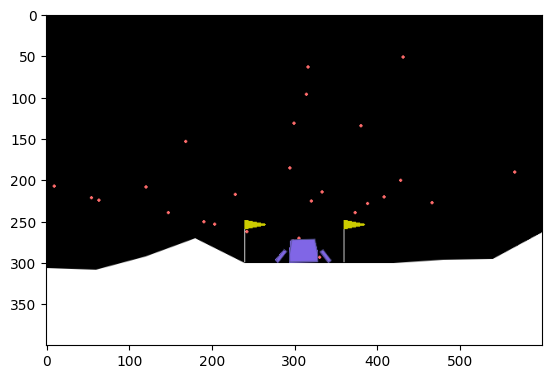

In [24]:
env.action_space.sample()
import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'))

display_video(episode=0)

#### Create the test/sampling function

#### Create the Deep Q-Learning algorithm

In [28]:
class DeepQLearning(LightningModule):
  def __init__(self, env_name, policy= epsilon_greedy, capacity =100_000,
               batch_size = 256, lr = 1e-3, hidden_size = 125, gamma = 0.99,
               loss_fn = F.smooth_l1_loss, optim = AdamW,
               eps_start =1.0, eps_end = 0.15, eps_last_episode = 100,
               samples_per_epoch = 10_000, sync_rate = 10 ):
    super().__init__()
    self.env = create_environment(env_name)

    obs_size = self.env.observation_space.shape[0]
    n_action = self.env.action_space.n

    #self.q_net = DQN(hidden_size=hidden_size, obs_size=obs_size, n_action=n_action)
    self.q_net = DQN(hidden_size, obs_size, n_action)

    self.target_q_net = copy.deepcopy(self.q_net)

    self.policy = policy
    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling ... ")
      self.play_episode(epsilon = self.hparams.eps_start)

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.0):
    state = self.env.reset()
    done = False

    while not done:
      if policy:
        action = policy(state, self.env, self.q_net, epsilon=epsilon)
      else:
        action = self.env.action_space.sample()
      next_state, reward, done, info = self.env.step(action)
      exp = (state, action, reward, done, next_state)
      self.buffer.append(exp)
      state = next_state

  # Forward.
  def forward(self, x):
    return self.q_net(x)

  def q_net_parameters(self):
    return self.q_net.parameters()

  # Configure Optimizer.
  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net_parameters(), lr=self.hparams.lr)
    return [q_net_optimizer] # put it in [] as we might use different NN and we'll have more than one optimizer

  # Create dataloader
  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader

  # Training step.
  def training_step(self, batch, batch_idx):
    states, actions, rewards, dones, next_states = batch
    actions = actions.unsqueeze(1)
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)

    state_action_values = self.q_net(states).gather(1, actions)

    next_action_values, _ = self.target_q_net(next_states).max(dim=1, keepdim=True)
    next_action_values[dones] = 0.0
    expected_state_action_values = rewards + self.hparams.gamma * next_action_values

    loss = self.hparams.loss_fn(state_action_values, expected_state_action_values)
    self.log('episode/Q_Error', loss)
    return loss

# Training epoch end.
  def on_train_epoch_end(self):
    epsilon = max(
        self.hparams.eps_end,
        self.hparams.eps_start - self.current_epoch / self.hparams.eps_last_episode
    )

    self.play_episode(policy=self.policy, epsilon=epsilon)
    self.log('episode/Return', self.env.return_queue[-1])
    returns = list(self.env.return_queue)[-100:]
    self.log('hp_metrics', statistics.mean(returns))

    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())



#### Create the objective function

#### Create the optimization study

#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
# Start tensorboard.
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Run the hyperparameter search

#### Select and use the best hyperparameters

In [ ]:
# Start tensorboard.
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Check the resulting policy